In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(font_scale = 1.8)

import asyncio
import httpx
import aiohttp

# Practical Motivation

Blockbuster films nowadays are being dominated by an influx of Action films that have burst onto the scene with high budgets and equally high profits. Before covid, one can be assured that with every new movie release cycle, there would be a handful of action films for people to simply turn off their brains and enjoy some crazy fights and carnage.

With this oversaturation of action movies, can one determine whether a movie is an `Action` film or not?

![Action Movies](https://s.studiobinder.com/wp-content/uploads/2020/05/Best-Action-Movies-of-All-Time-Featured-.jpg.webp)

# Sample Collection

First we'll be collecting data from The Movie Database's (TMDB) popular page. Each API call will retrieve one page from the popular list and each page contains 20 movies. 

Looping through the first 25 pages, we will try to get the top 500 popular movies. To avoid getting movies that have yet to be released and thus may have missing information in their pages, only movies with `Release Date` fields present will be acquired.

In [2]:
movieData = []

payload = {
        'api_key': '7b02292125cb5a1adfb93ac0c8a7f0b2',
        'language': 'en-US',
        'with_original_language': 'en'
    }

for i in range(1, 26):
    url = f"https://api.themoviedb.org/3/discover/movie?sort_by=popularity.desc&include_adult=false&include_video=false&page={i}"
    
    response = requests.get(url = url, params = payload)

    for mov in response.json()['results']:
        if 'release_date' in mov.keys():
            movieData.append([mov['original_title'], mov['release_date'], mov['overview'], mov['genre_ids']])
                  
movieData

[['Godzilla vs. Kong',
  '2021-03-24',
  'In a time when monsters walk the Earth, humanity’s fight for its future sets Godzilla and Kong on a collision course that will see the two most powerful forces of nature on the planet collide in a spectacular battle for the ages.',
  [28, 878]],
 ['Thunder Force',
  '2021-04-09',
  'In a world where supervillains are commonplace, two estranged childhood best friends reunite after one devises a treatment that gives them powers to protect their city.',
  [28, 12, 35, 14]],
 ["Zack Snyder's Justice League",
  '2021-03-18',
  "Determined to ensure Superman's ultimate sacrifice was not in vain, Bruce Wayne aligns forces with Diana Prince with plans to recruit a team of metahumans to protect the world from an approaching threat of catastrophic proportions.",
  [28, 12, 14, 878]],
 ['Mortal Kombat',
  '2021-04-07',
  "Washed-up MMA fighter Cole Young, unaware of his heritage, and hunted by Emperor Shang Tsung's best warrior, Sub-Zero, seeks out and tr

### Genre List

Before we check out the movie details, turns out that TMDB uses Genre IDs to represent each genre. Since these numbers won't mean anything to us unless we know their associated names, we will now retrieve the genre list via a similar API call, and then match the IDs to their respective genres

In [3]:
url = f"https://api.themoviedb.org/3/genre/movie/list?"

payload = {
        'api_key': '7b02292125cb5a1adfb93ac0c8a7f0b2',
        'language': 'en-US'
    }

genres = requests.get(url = url, params = payload)

genres = genres.json()['genres']

genreDict = {}

for item in genres:
    genreDict.update({item['id'] : item['name']})
    
genreDict

{28: 'Action',
 12: 'Adventure',
 16: 'Animation',
 35: 'Comedy',
 80: 'Crime',
 99: 'Documentary',
 18: 'Drama',
 10751: 'Family',
 14: 'Fantasy',
 36: 'History',
 27: 'Horror',
 10402: 'Music',
 9648: 'Mystery',
 10749: 'Romance',
 878: 'Science Fiction',
 10770: 'TV Movie',
 53: 'Thriller',
 10752: 'War',
 37: 'Western'}

### Popular Movie Dataframe

Let's go ahead and create the dataframe with the data we retrieved and use the Genre IDs to find their respective genre.

In [4]:
movieDataDF = pd.DataFrame(movieData, columns = ['Title', 'Release Date', 'Overview', 'Genres'])

popularDF = movieDataDF.copy(deep = True)

for genlist in popularDF['Genres']:
    for i in range(len(genlist)):
        genlist.append(genreDict[genlist.pop(0)])
        
popularDF.head()

,Title,Release Date,Overview,Genres
0,Godzilla vs. Kong,2021-03-24,"In a time when monsters walk the Earth, humani...","[Action, Science Fiction]"
1,Thunder Force,2021-04-09,In a world where supervillains are commonplace...,"[Action, Adventure, Comedy, Fantasy]"
2,Zack Snyder's Justice League,2021-03-18,Determined to ensure Superman's ultimate sacri...,"[Action, Adventure, Fantasy, Science Fiction]"
3,Mortal Kombat,2021-04-07,"Washed-up MMA fighter Cole Young, unaware of h...","[Fantasy, Action, Adventure]"
4,The Marksman,2021-01-15,Jim Hanson’s quiet life is suddenly disturbed ...,"[Action, Thriller, Crime]"


In [5]:
popularDF.shape

(498, 4)

### Extracting the Genres

We're now going to extract all the `genres` so that we can perform some basic exploratory data analysis.

In [6]:
popGenList = []
for movieGenList in popularDF['Genres']:
    for genre in movieGenList:
        popGenList.append(genre)

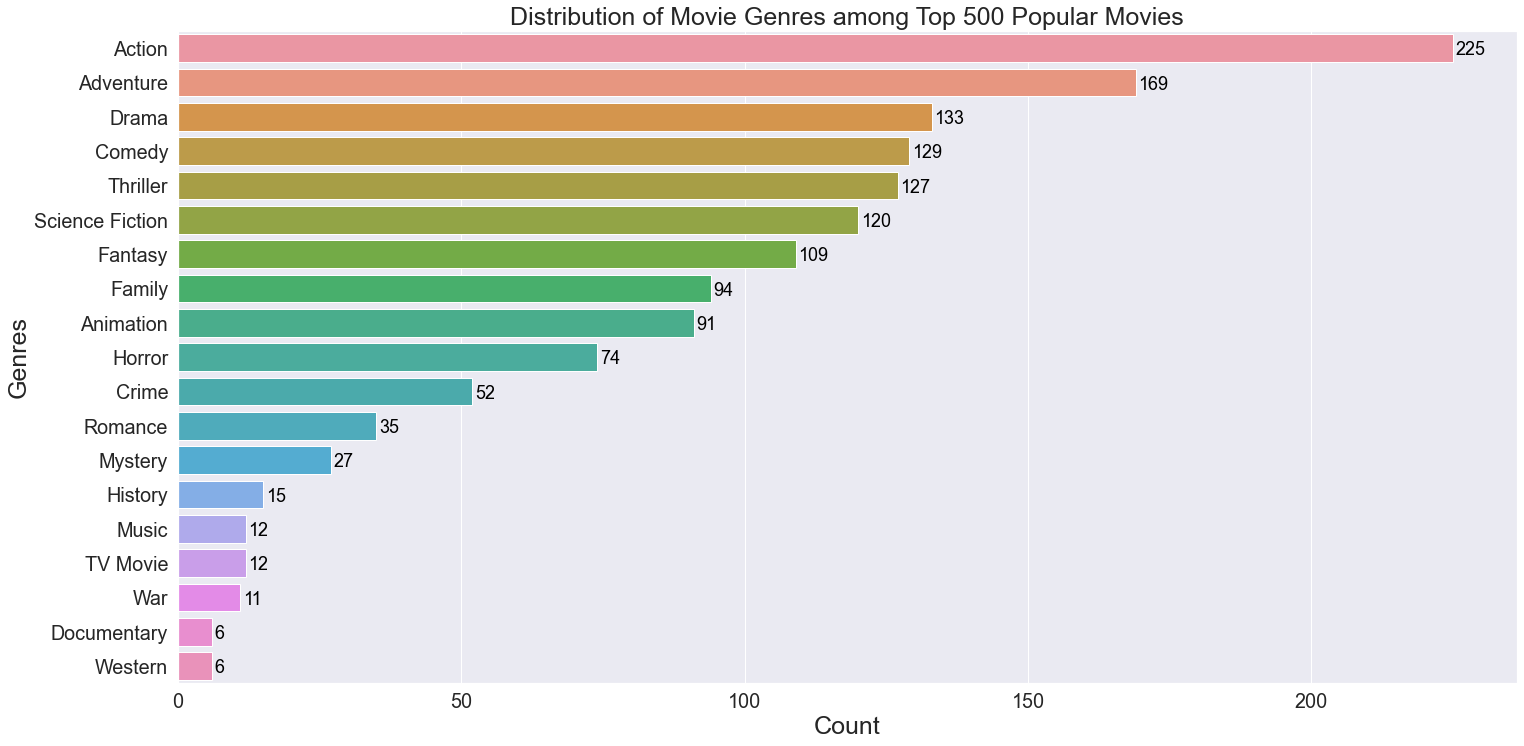

In [7]:
genreDF = pd.DataFrame(popGenList, columns = ['Genres'])
genreDF = genreDF.astype('category')


# Plot the distribution of Genre's among the top 500 popular movies
f = plt.figure(figsize = (24,12))
ax = sb.countplot(data = genreDF, y = genreDF['Genres'], order = genreDF['Genres'].value_counts().index)
ax.set_title('Distribution of Movie Genres among Top 500 Popular Movies', fontsize = 25)
ax.set_ylabel("Genres", fontsize = 25)
ax.set_xlabel("Count", fontsize = 25)

for p in ax.patches:
    ax.annotate(f'\n{p.get_width()}', (p.get_width() + 0.5, p.get_y() + 0.6), color='black', size=18)

In [8]:
print("Percentage of Popular Movies that contains {} = {}%".format(genreDF.mode()['Genres'][0],round(genreDF.value_counts()[0]/len(popularDF) * 100, 2)))

Percentage of Popular Movies that contains Action = 45.18%


# Problem Formulation

From the graph above, we can see that `Action` is still the most common `Genre` among the popular movies. It accounts for about 44% of the popular movie genres. 

In order to predict whether a movie is an `Action` movie, we will need to examine the statistics that each movie is associated with, such as `Budget`, `Revenue` or `Popularity`. We may also examine unstructured data such as `Overview` which we can use later on in a different kind of machine learning model.

To begin, let us first see if we can predict whether a given movie has `Action` as a `Genre` via numeric predictors and binary classification.

![Movie Genres](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fstatic.vecteezy.com%2Fsystem%2Fresources%2Fpreviews%2F000%2F435%2F002%2Foriginal%2Fvector-film-genres-icon-set.jpg&f=1&nofb=1)

# Data Preparation

We'll start by extracting about 10,000 movies that have `Action` and another 10,000 that don't have it, all of which, will be from the popular movie listing of TMDB. This will give us a more balanced data set to work with. From these movies, the predictors that we will be extracting and using are:

> `Budget`  
> `Run Time`  
> `Revenue`  
> `Popularity`  
> `Vote Average`  
> `Vote Count`


## Data Extraction
In order to speed the data acquisition, we will be utilising co-operative multitasking to make multiple API calls at the same time, greatly reducing the time needed to make multiple API calls one after another. We will use this method to extract all 500 pages from Popular Movies and subsequently we will extract their movie IDs.

In [9]:
async def gatherPages(num, url):

    # Coroutine that will perform the API call
    async def gather_with_concurrency(n, *tasks):
        semaphore = asyncio.Semaphore(n)
        
        async def sem_task(task):
            async with semaphore:
                return await task
        
        return await asyncio.gather(*(sem_task(task) for task in tasks))
    
    # Coroutine object to retrieve one page
    async def get_response(page):
        async with aiohttp.ClientSession() as session:
            pageUrl = url + f"&page={page}"
            async with session.get(pageUrl) as response:
                return await response.json()
    
    # Coroutine that creates a list of couroutines that will later be executed 
    async def main(pages):
        taskList = []
        for page in pages:
            task = asyncio.ensure_future(get_response(page))
            taskList.append(task)
        idList = await gather_with_concurrency(60, *taskList)
        return idList
    
    pageList = [i for i in range(1, num + 1)]
    popPages = await main(pageList)
    return popPages

In [10]:
url = "https://api.themoviedb.org/3/discover/movie?api_key=7b02292125cb5a1adfb93ac0c8a7f0b2&language=en-US&sort_by=popularity.desc&include_adult=false&include_video=false&with_genres=28&with_original_language=en"
pageList = await gatherPages(500, url)

actionIDList = []
for page in pageList:
    for movie in page['results']:
        actionIDList.append(movie['id'])

In [11]:
async def gatherMovies(idList):
    
    # Coroutine that will perform the API call
    async def gather_with_concurrency(n, *tasks):
        semaphore = asyncio.Semaphore(n)
        
        async def sem_task(task):
            async with semaphore:
                return await task
        
        return await asyncio.gather(*(sem_task(task) for task in tasks))
    
    # Coroutine object to retrieve one page
    async def get_response(idNum):
        async with aiohttp.ClientSession() as session:
            url = f"https://api.themoviedb.org/3/movie/{idNum}?api_key=7b02292125cb5a1adfb93ac0c8a7f0b2&language=en-US"
            async with session.get(url) as response:
                return await response.json()
    
    # Coroutine that creates a list of couroutines that will later be executed 
    async def main(pages):
        taskList = []
        for page in pages:
            task = asyncio.ensure_future(get_response(page))
            taskList.append(task)
        idList = await gather_with_concurrency(1000, *taskList)
        return idList
    
    movieList = []
    for i in range(len(idList)//1000 + 1):
        ids = idList[i * 1000 : (i+1) * 1000]
        movieList.extend(await main(ids))

    
    return pd.DataFrame(movieList) 

In [12]:
actionDF = await gatherMovies(actionIDList)
actionDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  9997 non-null   object 
 1   backdrop_path          6399 non-null   object 
 2   belongs_to_collection  1518 non-null   object 
 3   budget                 9997 non-null   float64
 4   genres                 9997 non-null   object 
 5   homepage               9753 non-null   object 
 6   id                     9997 non-null   float64
 7   imdb_id                9861 non-null   object 
 8   original_language      9997 non-null   object 
 9   original_title         9997 non-null   object 
 10  overview               9997 non-null   object 
 11  popularity             9997 non-null   float64
 12  poster_path            9165 non-null   object 
 13  production_companies   9997 non-null   object 
 14  production_countries   9997 non-null   object 
 15  rele

In [13]:
url = "https://api.themoviedb.org/3/discover/movie?api_key=7b02292125cb5a1adfb93ac0c8a7f0b2&language=en-US&sort_by=popularity.desc&include_adult=false&include_video=false&without_genres=28&with_original_language=en"
pageList = await gatherPages(500, url)

notActionIDList = []
for page in pageList:
    for movie in page['results']:
        notActionIDList.append(movie['id'])

In [14]:
notActionDF = await gatherMovies(notActionIDList)
notActionDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  9999 non-null   object 
 1   backdrop_path          9457 non-null   object 
 2   belongs_to_collection  1654 non-null   object 
 3   budget                 9999 non-null   float64
 4   genres                 9999 non-null   object 
 5   homepage               9974 non-null   object 
 6   id                     9999 non-null   float64
 7   imdb_id                9920 non-null   object 
 8   original_language      9999 non-null   object 
 9   original_title         9999 non-null   object 
 10  overview               9999 non-null   object 
 11  popularity             9999 non-null   float64
 12  poster_path            9958 non-null   object 
 13  production_companies   9999 non-null   object 
 14  production_countries   9999 non-null   object 
 15  rel

## Data Cleaning and Preparation

Now that we have extracted our data, we can begin filtering out the unneccessary information such as `adult` and `poster_path`, and only retain the information valuable to us for analysis. The parameters that we will be keeping are:
> `Budget`  
> `Genres`  
> `Original Language`  
> `Overview`  
> `Popularity`  
> `Revenue`  
> `Runtime`  
> `Status`  
> `Tagline`  
> `Title`  
> `Vote Average`  
> `Vote Count`

In [15]:
cleanActionDF = actionDF.drop(['adult', 'backdrop_path', 'belongs_to_collection', 'homepage', 'id', 'imdb_id', 'original_title', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'spoken_languages', 'status', 'video', 'success', 'status_code', 'status_message'], axis = 1)
cleanNotActionDF = notActionDF.drop(['adult', 'backdrop_path', 'belongs_to_collection', 'homepage', 'id', 'imdb_id', 'original_title', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'spoken_languages', 'status', 'video', 'success', 'status_code', 'status_message'], axis = 1)

cleanActionDF.columns =  ['Budget', 'Genres', 'Original Language', 'Overview', 'Popularity', 'Revenue', 'Runtime', 'Tagline', 'Title', 'Vote Average', 'Vote Count']
cleanNotActionDF.columns = ['Budget', 'Genres', 'Original Language', 'Overview', 'Popularity', 'Revenue', 'Runtime', 'Tagline', 'Title', 'Vote Average', 'Vote Count']

In [16]:
cleanPredictors = ['Budget', 'Revenue', 'Runtime', 'Vote Count']

# Removie movies that have a 0 value for the predictors in cleanPredictors above
for pred in cleanPredictors:
    cleanActionDF.drop(index = cleanActionDF[cleanActionDF[pred] == 0].index, inplace = True)
    cleanNotActionDF.drop(index = cleanNotActionDF[cleanNotActionDF[pred] == 0].index, inplace = True)

# Removing movies whose language is not English
cleanActionDF.drop(index = cleanActionDF[cleanActionDF['Original Language'] != 'en'].index, inplace = True)
cleanNotActionDF.drop(index = cleanNotActionDF[cleanNotActionDF['Original Language'] != 'en'].index, inplace = True)

# Extracting the genres for each movie
totalGenreList = genreDict.values()

for genres in cleanActionDF['Genres']:
    for i in range(len(genres)):
        genres.append(genres.pop(0)['name'])

for genres in cleanNotActionDF['Genres']:
    for i in range(len(genres)):
        genres.append(genres.pop(0)['name'])

# Reset the index now that we have missing indexes after dropping movies
cleanActionDF.reset_index(drop = True, inplace = True)
cleanNotActionDF.reset_index(drop = True, inplace = True)

In [17]:
print('Dimensions of Action Movies: ', cleanActionDF.shape)
print('Dimensions of Non-Action Movies: ', cleanNotActionDF.shape)

Dimensions of Action Movies:  (1474, 11)
Dimensions of Non-Action Movies:  (3750, 11)


### Class Imbalance

Based on the shape of the two dataframes, we can see that we are left with over twice as many `Non-Action` movies as there are `Action` movies. In order to balance the classes, we shall perform random sampling on the `Non-Action` movies and only take an equal number of movies to `Action`. 

In [18]:
originalCleanNotActionDF = cleanNotActionDF.copy(deep = True)

In [19]:
from sklearn.utils import resample

cleanNotActionDF = resample(cleanNotActionDF, replace = False, n_samples = len(cleanActionDF), random_state = 42)

print('Dimensions of Action Movies: ', cleanActionDF.shape)
print('Dimensions of Non-Action Movies: ', cleanNotActionDF.shape)

Dimensions of Action Movies:  (1474, 11)
Dimensions of Non-Action Movies:  (1474, 11)


# Exploratory Data Analysis

![Exploratory Data Analysis](https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fwww.liyanatech.com%2Fwp-content%2Fuploads%2F2014%2F11%2Fdata_analysis.jpg&f=1&nofb=1)

## Univariate Statistics
We will now perform some basic univariate statistical analysis on the follwing six numeric predictors, in order to visualise the differences among these variables between `Action` and `Non-Action` movies:
>`Budget`  
>`Popularity`  
>`Revenue`  
>`Runtime`  
>`Vote Average`  
>`Vote Count`

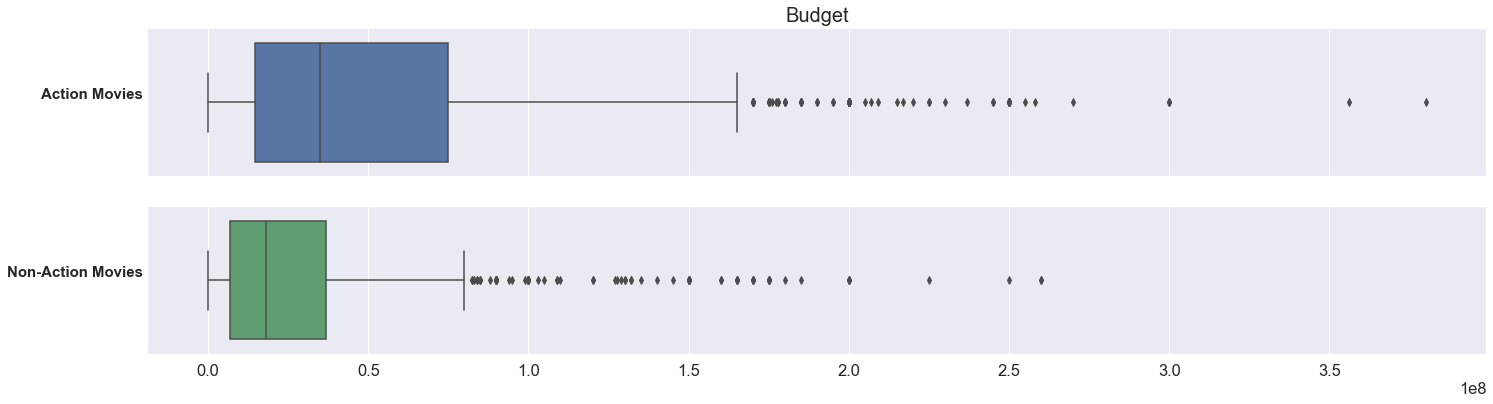

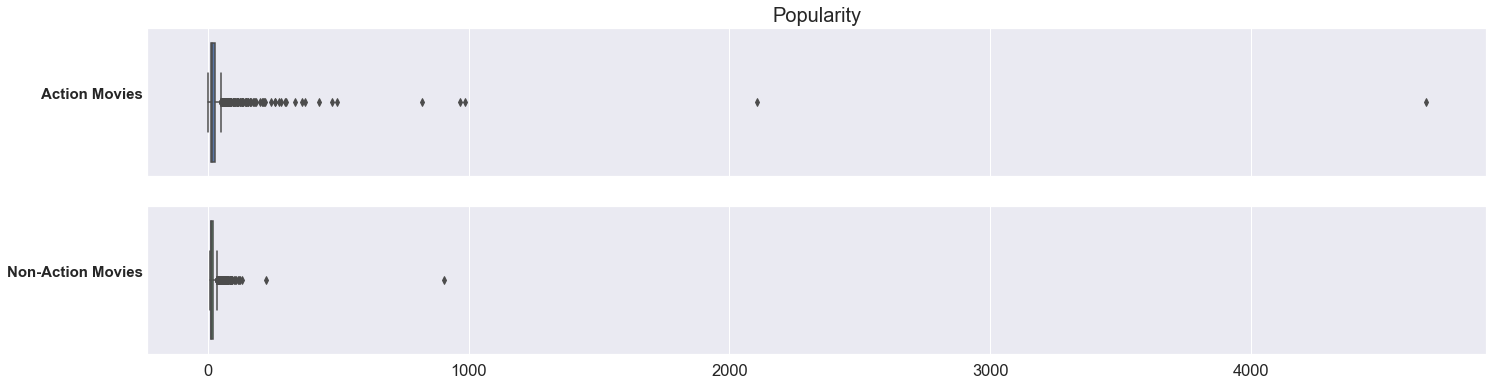

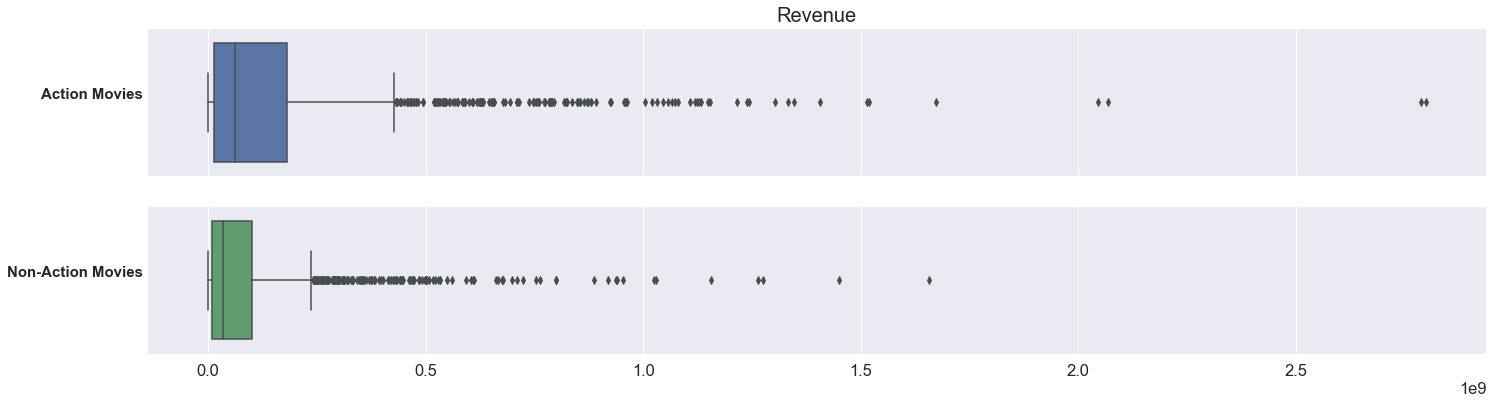

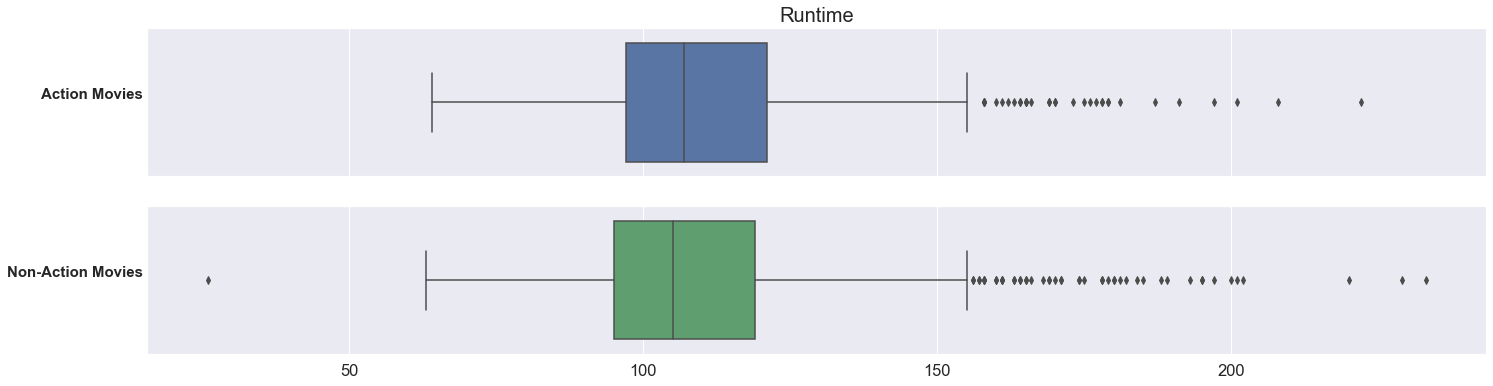

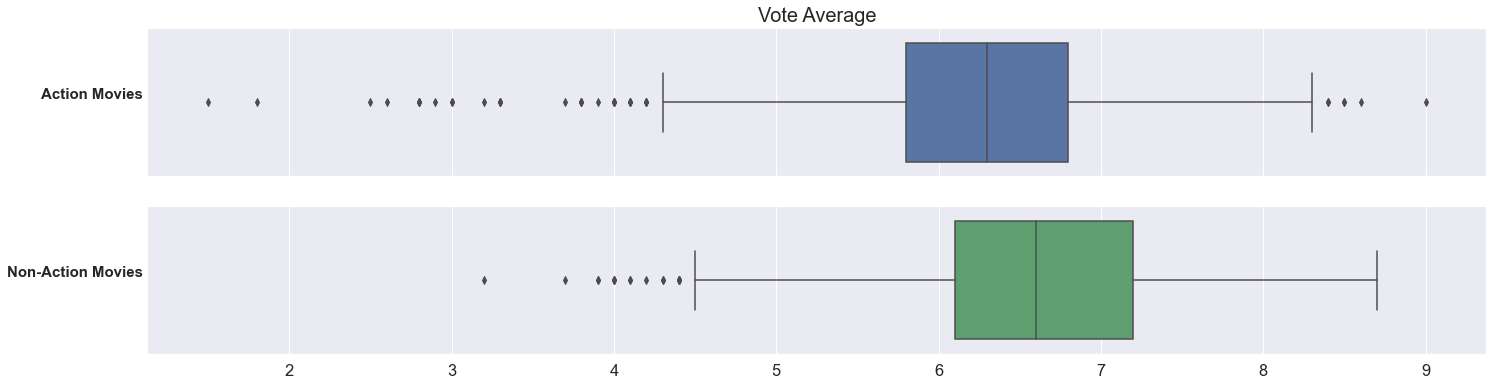

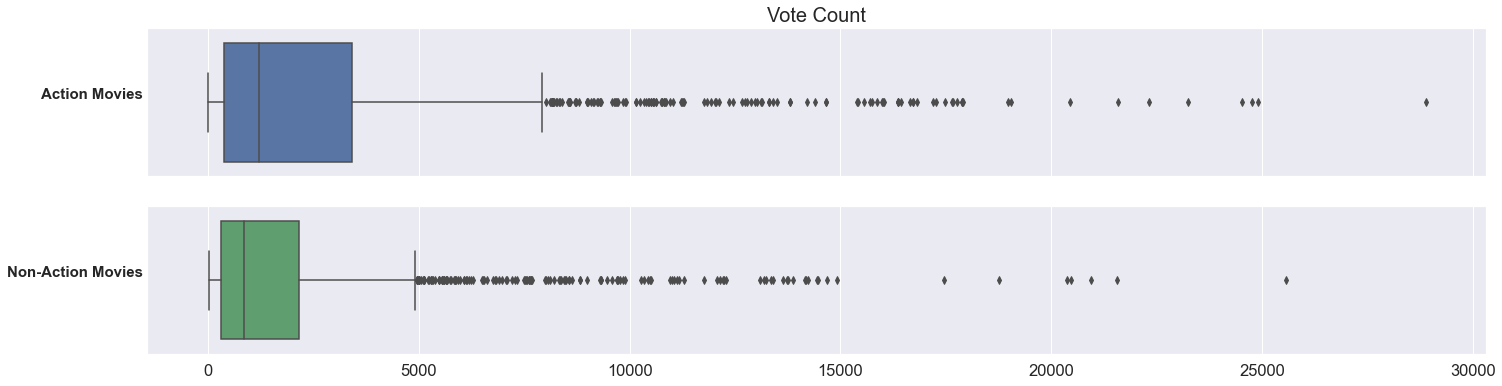

In [20]:
predictors = ['Budget', 'Popularity', 'Revenue', 'Runtime', 'Vote Average', 'Vote Count']
sb.set(font_scale = 1.5)

for pred in predictors:
    f, axes = plt.subplots(2, 1, figsize=(24, 6), sharex = 'all')
    plt.subplots_adjust(hspace = 0.2)
    
    axes[0].set_title(pred, fontsize = 20)
    
    sb.boxplot(data = cleanActionDF[pred], orient='h', ax = axes[0])
    axes[0].set_ylabel('Action Movies', fontsize = 15, rotation = 'horizontal', fontweight = 'bold', horizontalalignment = 'right')
    axes[0].set_yticks(ticks = [])
    
    sb.boxplot(data = cleanNotActionDF[pred], orient='h', color = 'g', ax = axes[1])
    axes[1].set_ylabel('Non-Action Movies', fontsize = 15, rotation = 'horizontal', fontweight = 'bold', horizontalalignment = 'right')
    axes[1].set_yticks(ticks = [])

### Taking Log of Highly Right Skewed Predictors

As we can see from above, the values in `Revenue`, `Popularity` and `Vote Count` are highly right skewed, meaning there are certain outliers among the data that have values far above the upper limit which is distorting the boxplot's ability to portray detailed visualisation of the predictors. 

This, in order to visualise the scale of the differences in these predictors, we will take the natural log of their valies - which will push values that are further from the median towards the centre.

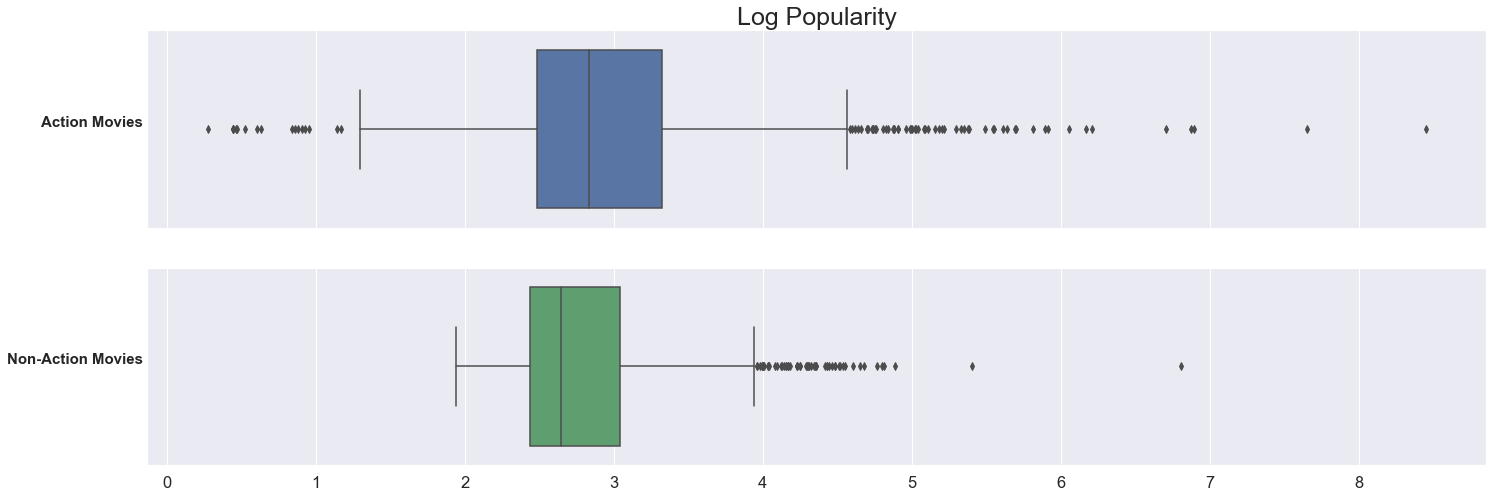

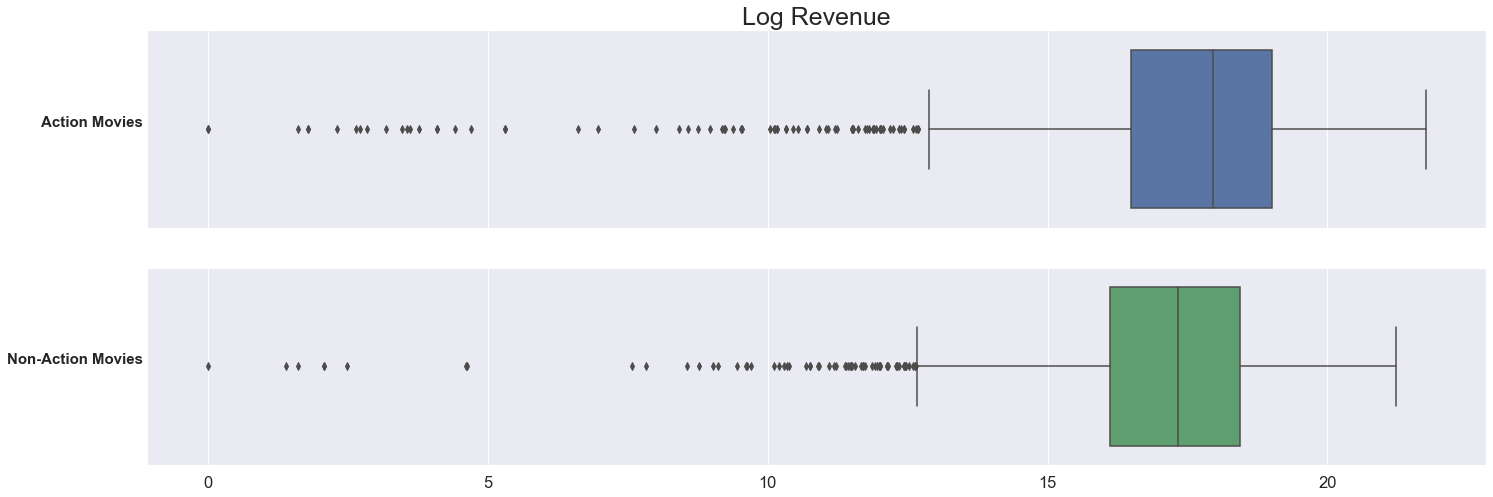

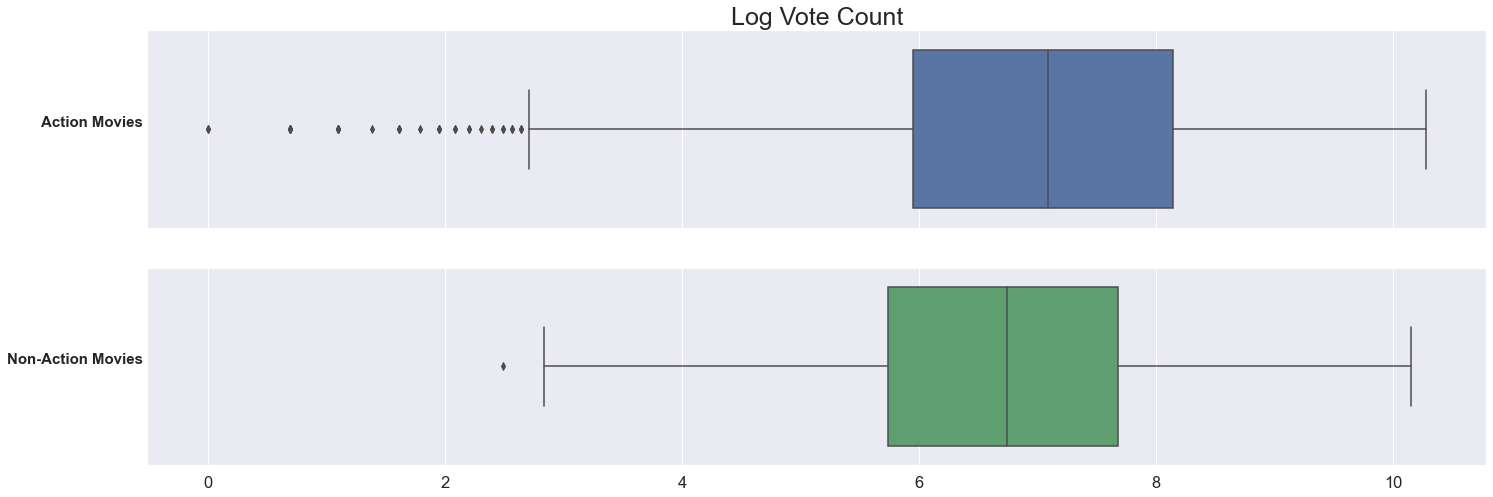

In [21]:
cleanActionDF['Log Revenue'] = np.log(cleanActionDF['Revenue'])
cleanNotActionDF['Log Revenue'] = np.log(cleanNotActionDF['Revenue'])

cleanActionDF['Log Popularity'] = np.log(cleanActionDF['Popularity'])
cleanNotActionDF['Log Popularity'] = np.log(cleanNotActionDF['Popularity'])

cleanActionDF['Log Vote Count'] = np.log(cleanActionDF['Vote Count'])
cleanNotActionDF['Log Vote Count'] = np.log(cleanNotActionDF['Vote Count'])

logPredictors = ['Log Popularity', 'Log Revenue', 'Log Vote Count']

for pred in logPredictors:
    
    f, axes = plt.subplots(2,1,figsize=(24,8), sharex = 'all')

    axes[0].set_title(pred, fontsize = 25)

    sb.boxplot(data = cleanActionDF[pred], orient='h', ax = axes[0])
    axes[0].set_ylabel('Action Movies', fontsize = 15, rotation = 'horizontal', fontweight = 'bold', horizontalalignment = 'right')
    axes[0].set_yticks(ticks = [])

    sb.boxplot(data = cleanNotActionDF[pred], orient='h', color = 'g', ax = axes[1])
    axes[1].set_ylabel('Non-Action Movies', fontsize = 15, rotation = 'horizontal', fontweight = 'bold', horizontalalignment = 'right')
    axes[1].set_yticks(ticks = [])

## Multivariate Statistical Analysis

We will now perform some basic multivariate analysis, to visualise the effect of the predictors on whether or not a movie is an `Action` movie or not.

Before that we will first create a new column to indicate whether a movie is an `Action` movie or not - using True and False boolean values.

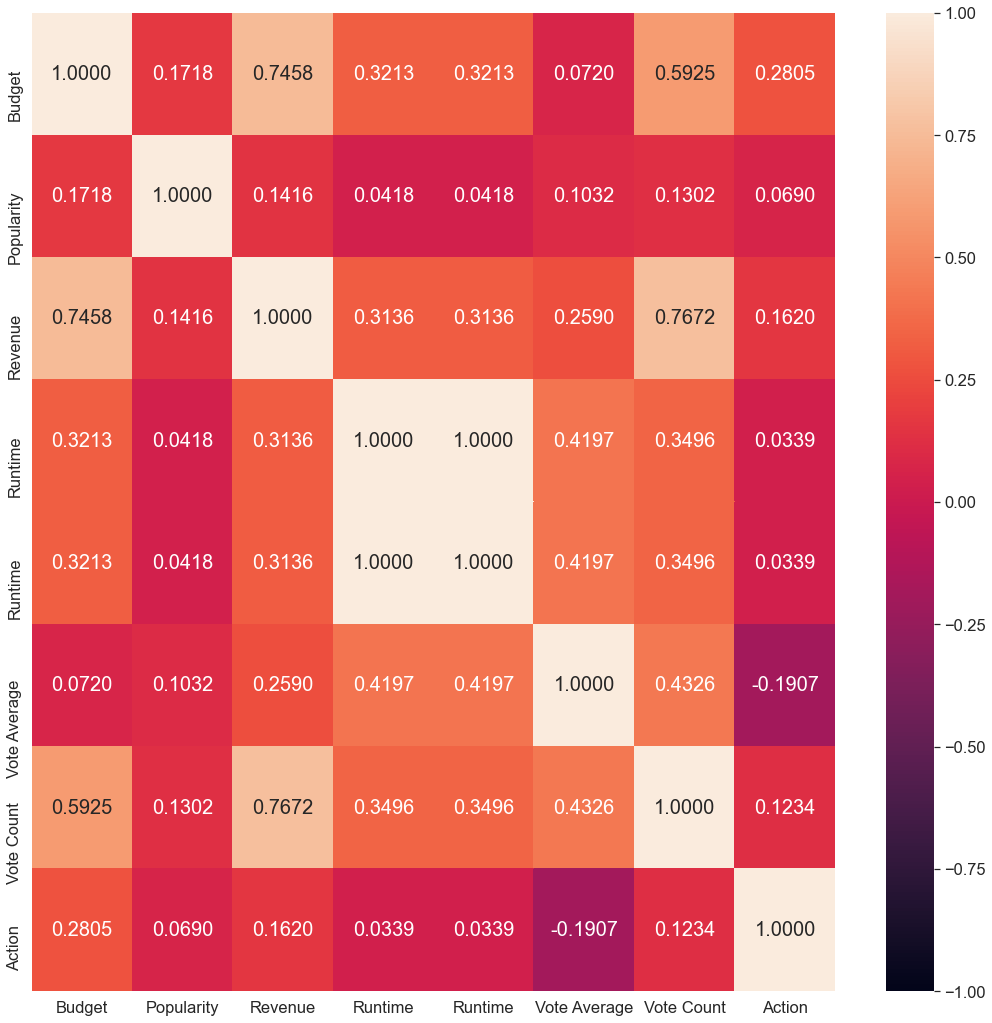

In [22]:
cleanActionDF['Action'] = True
cleanNotActionDF['Action'] = False

combinedMoviesDF = cleanActionDF.append(cleanNotActionDF)
corrCols = ['Budget', 'Popularity', 'Revenue', 'Runtime', 'Runtime', 'Vote Average', 'Vote Count', 'Action']

f = plt.figure(figsize = (18,18))
corrHM = sb.heatmap(combinedMoviesDF[corrCols].corr(), vmin = -1, vmax = 1, annot = True, fmt = ".4f", annot_kws = {'size': 20})

We can see that `Runtime` and `Popularity` have the lowest correlation with `Action`.

With this new data-driven insight, we shall not use `Runtime` and `Popularity` when training our machine models as they are least likely to be useful in our prediction and it would also avoid any overfitting or overtraining of our classification model.

# Binary Classification

Using the predictors, we will now perform a multivariate binary classification to predict whether a movie is an `Action` movie or not.

In [23]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6476707372229761

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6458616010854816



Text(0.5, 1.0, 'Test Data')

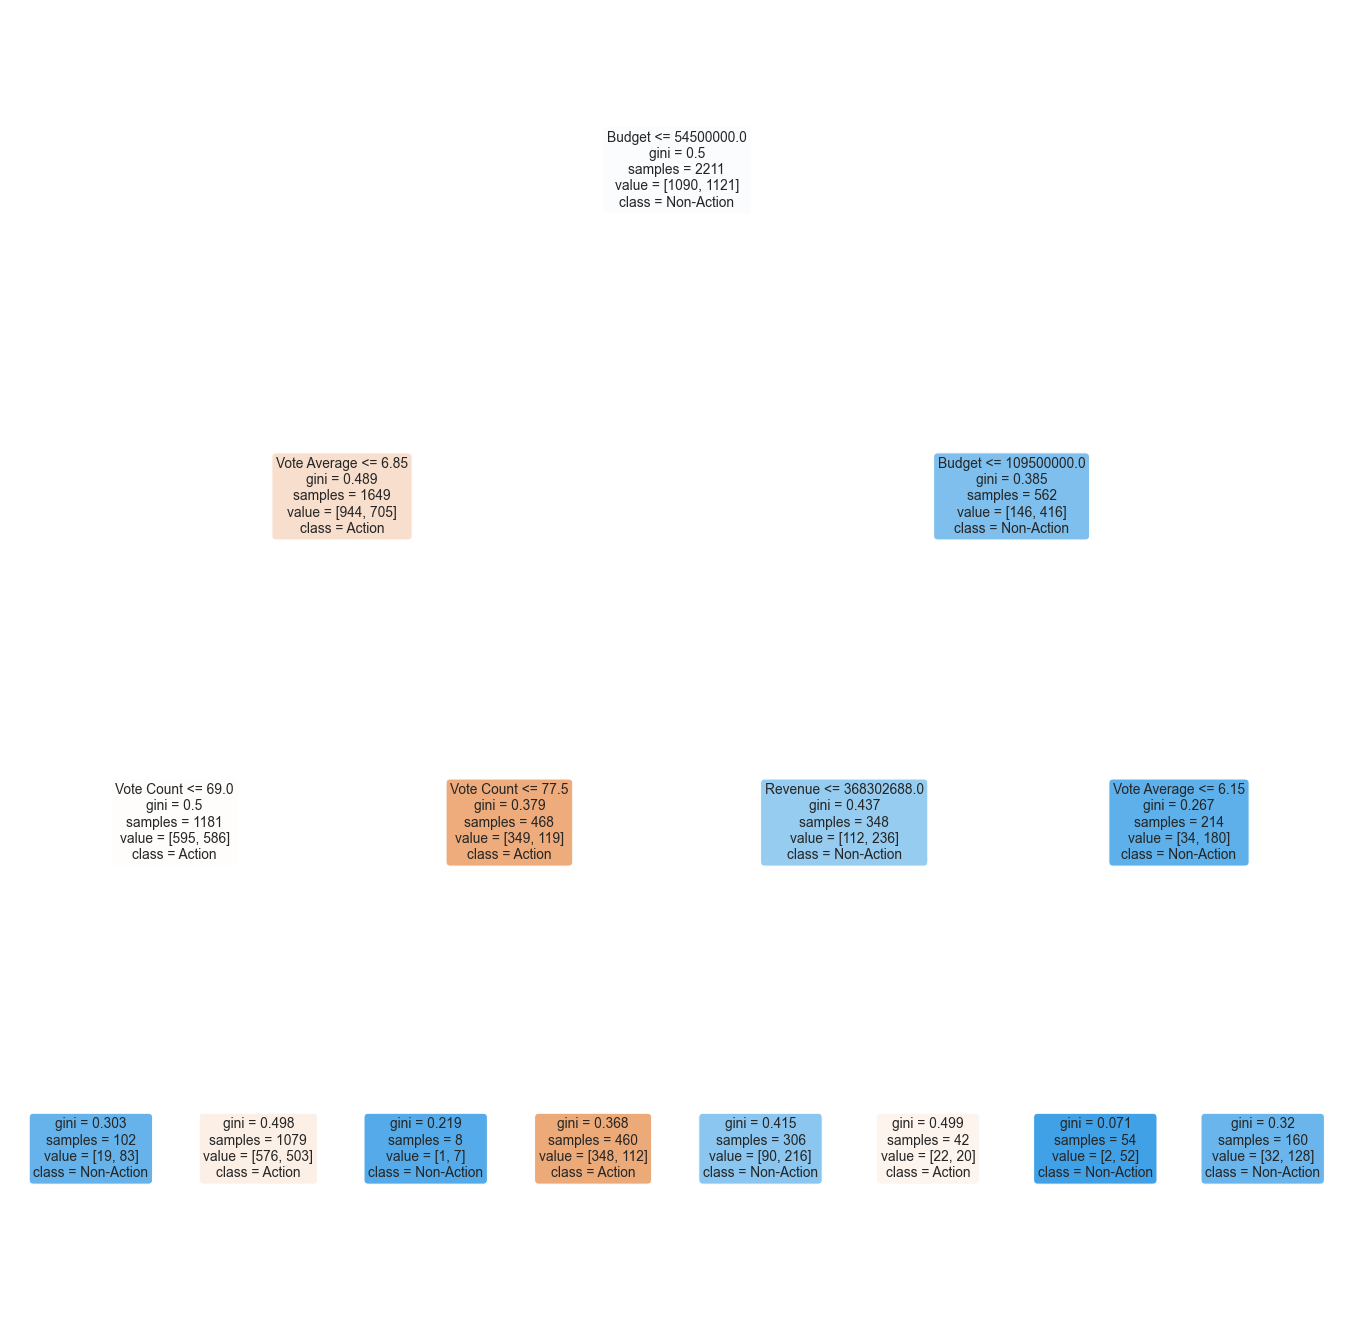

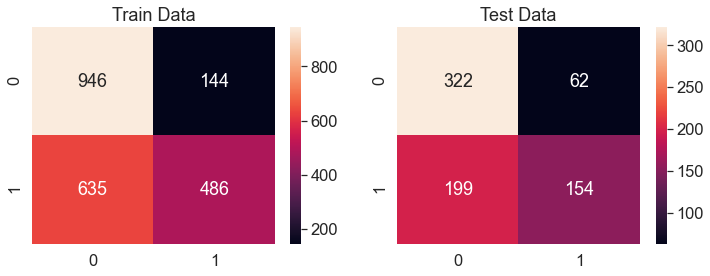

In [24]:
# Shuffle the rows of the Dataframe
combinedMoviesDF = combinedMoviesDF.sample(frac = 1)

# Extract Response and Predictors
y = pd.DataFrame(combinedMoviesDF['Action'])
X = pd.DataFrame(combinedMoviesDF[['Budget', 'Revenue', 'Vote Average', 'Vote Count']]) 

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 3)  # create the decision tree object
dectree.fit(X_train, y_train)                    # train the decision tree model

#Plot the decision tree
f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["Action","Non-Action"])

# Predict Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
trainHM = sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
trainHM.set_title('Train Data')

testHM = sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
testHM.set_title('Test Data')

### F1 score

We can use F1 score to test the effectiveness of our model in predicting whether a movie is an `Action` Movie.

F1 score uses:

> $\text{Precision} =\frac{TP}{(TP+TN)}$  

> $\text{Recall} = \frac{TP}{(TP+FN)}$

F1 score combines both _Precision_ and _Recall_, and is commonly used to evaluate binary classification models.  

$$\text{F1 score} = 2\times \frac{Precision \times Recall}{Precision + Recall}$$

In [25]:
# Performance metric
from sklearn.metrics import f1_score

f1_score(y_test, y_test_pred, average="micro")

0.6458616010854816

Based on the average classification accuracy and F1 score of about 0.64, we can conclude that a binary classification model that uses numeric variables to predict whether a movie is an `Action` movie is only reasonably accurate. 


Based on the confusion matrix, we can see that there is a high number of false negatives, meaning that the model tends to more often classify `Action` movies as `Non-Action`. In general this has contributed to the lower accuracy of the model.

# Using Natural Language Processing

![Natural Language Processing](https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fdatapandas.com%2Fwp-content%2Fuploads%2F2016%2F09%2Fnatural-language-processing.gif&f=1&nofb=1)

Now we will try to see if non-structured data, such as text, can be useful in differentiating an `Action` movie from other movies.

In our project, we will look at `Overview`, and how the **words** in the overview can help us determine whether a movie is an `Action` movie.

We first start by processing the text in overview to make it more readable for machine learning.

In [26]:
import re

# function for text cleaning
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [27]:
combinedMoviesDF['Clean Overview'] = combinedMoviesDF['Overview'].apply(lambda x: clean_text(x))

### Natural Language Toolkit - NLTK's FreqDist

We would like to take a first glance at the frequency distribution of words throughout the overviews after some basic cleaning.  
Here, we use `nltk`'s FreqDist function to generate the distribution.

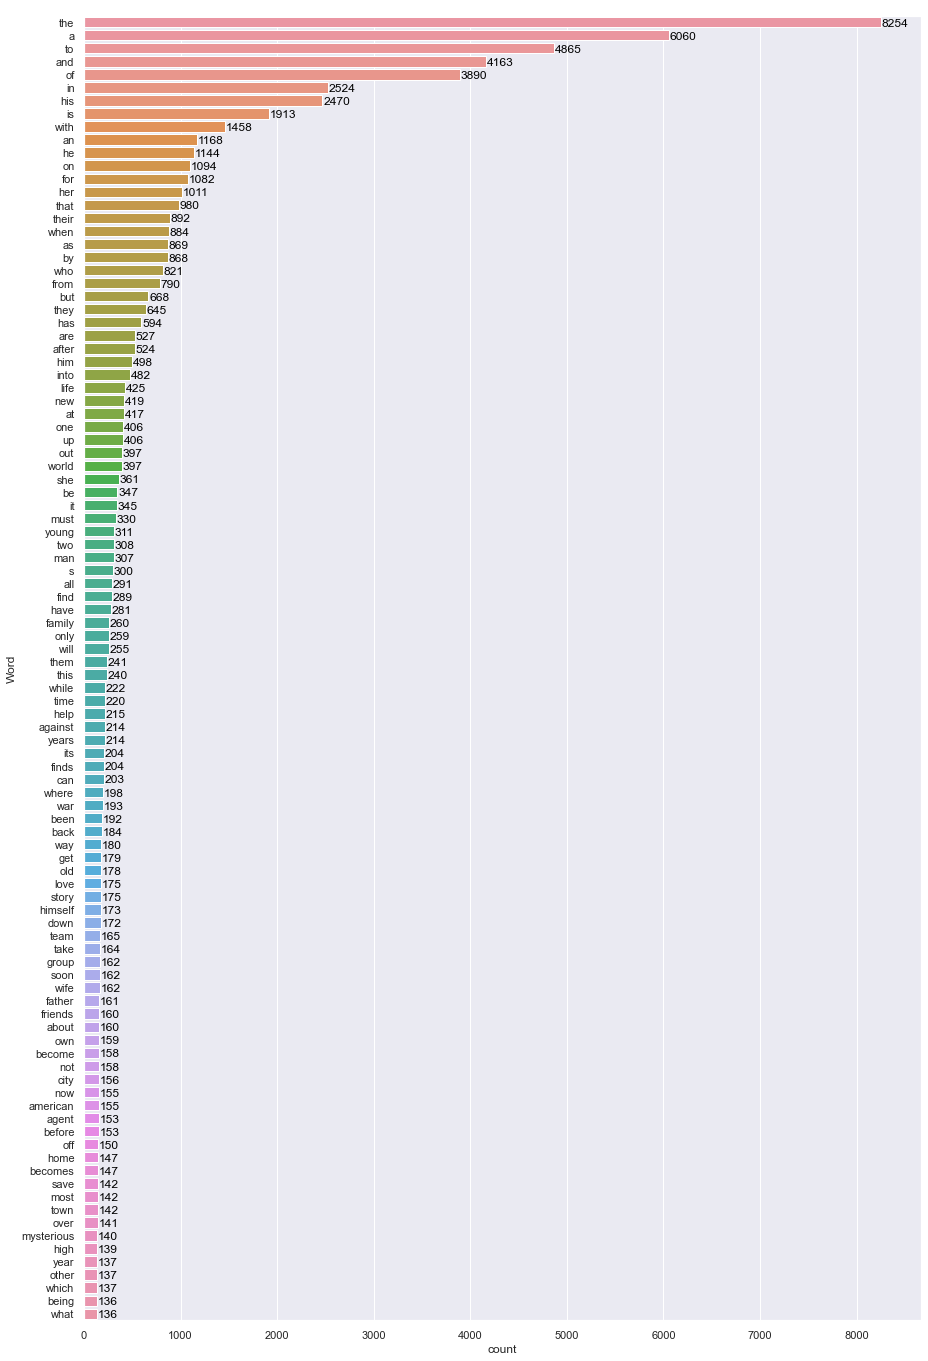

In [28]:
import nltk

def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 

    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 

    # visualize words and frequencies
    plt.figure(figsize=(15,24))
    sb.set()
    ax = sb.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    for p in ax.patches:
        ax.annotate(f'\n{int(p.get_width())}', (p.get_width() + 7, p.get_y() + 0.7), color='black', size=12)
        
    plt.show()

# print 100 most frequent words 
freq_words(combinedMoviesDF['Clean Overview'], 100)

As we can see, most of the word distribution goes to particular words like **'the', 'a', 'to'** and so forth.  
These are _stopwords_, and logically have little value in allowing us to determine the genre of a movie. So, we need to do more cleaning.

NLTK has a library called `stopwords` which has a list of stopwords stored in 16 different languages. In this case, we only need the English Library.

In [29]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

combinedMoviesDF['Clean Overview'] = combinedMoviesDF['Clean Overview'].apply(lambda x: remove_stopwords(x))

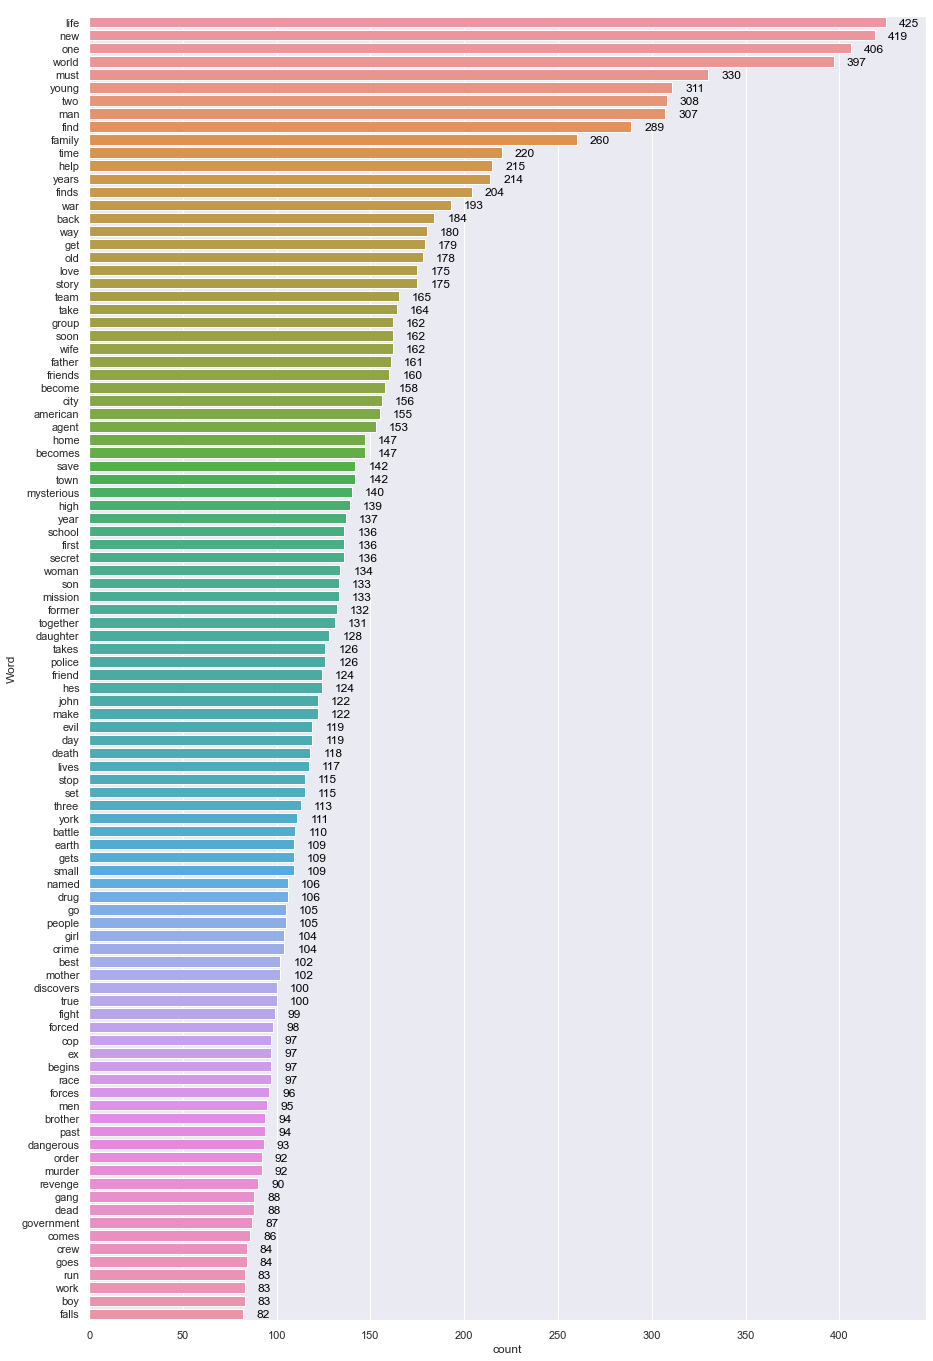

In [30]:
freq_words(combinedMoviesDF['Clean Overview'], 100)

This is much better as we are only left with words that have greater significance in allowing us to sieve out the genre.  

Now, we can once again split our data into training and test data and subsequently train our machine learning model. 

In [31]:
# split dataset into training and validation set
y = combinedMoviesDF['Action']
X = combinedMoviesDF['Clean Overview']

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

### Importing Machine Learning Model

For this, we will be using **Multinomial Naive Bayes model** from SKLearn.

Essentially, `Naive Bayes` helps us to filter `Non-Action` Movies from `Action` Movies by generating the **probability / likelihood** of seeing a specific word in the overview of an `Action` Movie.

This is done by multiplying the probability that the overview is for an $\text{Action} (A)$ / $\text{Non-Action Movies}(NA)$, and the probabilities that each word is from an Action/Non-Action movie (W1,W2...)

$P(A|Overview) = p(A) \times p(W1|A) \times p(W2|A) \times p(W3|A)...  $  

$P(NA|Overview) = p(NA) \times p(W1|NA) \times p(W2|NA) \times p(W3|NA)...$

When we compare the two probabilities, if P(A|Overview) > P(NA|Overview), we will decide that `Overview` is for an `Action` Movie. Otherwise, we consider that `Overview` as a `Non-Action` Movie.

The weakness in this model is that it does not take into account the order of the words, that's what makes Naive Bayes, _"naive"_  
But not to worry, the model is known to perform well even with this weakness.

`MultinomialNB` implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts)

In [32]:
#Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

### Count Vectorizer

Count Vectorizer is a feature in sklearn which manipulates the data in a few steps
1. Tokenising every word in the overview by assigning each word to an integer id
2. Count the number of occurrences of each particular word in each overview
3. Returns a matrix of the frequency of words in each overview  

Multinomial NB takes this matrix and generates the probability of each word belonging to an `Action` or `Non-Action` overview. When it comes to predicting whether an `Overview` belongs to an `Action` or `Non-Action` movie, it takes the probabilities of all the words in the overview to come to a final conclusion


In [33]:
#CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [34]:
vect = CountVectorizer().fit(X_train)
X_train_vectorized = vect.transform(X_train)
clfrNB = MultinomialNB(alpha = 0.1)
clfrNB.fit(X_train_vectorized, y_train)

MultinomialNB(alpha=0.1)

`fit(raw_documents[, y])` - Learn a vocabulary dictionary of all tokens in the raw documents.  
`fit_transform(raw_documents[, y])` - Learn the vocabulary dictionary and return document-term matrix.


`alpha` as a parameter for MultinomialNB is supposed to serve as an additive/smoothing parameter. This is in case a word does not appear at all in `Overview`'s of `Non-Action` movies, causing the probability to disregard the probability of other words appearing in the overview of `Non-Action` movies. This would cause us to predict incorrectly that a movie is `Action`/`Non-Action` when it is in fact not.

In [35]:
y_train_pred = clfrNB.predict(vect.transform(X_train))

### ROC AUC Score
This score can be used to test the ability of classifiers.

In [36]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_train_pred)

0.9880757245528395

Surprisingly, the training has gone very well, and the score is close to 1!  

This suggests that we are using an excellent classifier.

In [37]:
y_test_pred = clfrNB.predict(vect.transform(X_test))
roc_auc_score(y_test, y_test_pred)

0.7664548712935808

Not too bad, the score being more than 0.5 suggests that there is a high chance that the classifier will be able to distinguish `Action` from `Non-Action` movies.

Text(0.5, 1.0, 'Test Data')

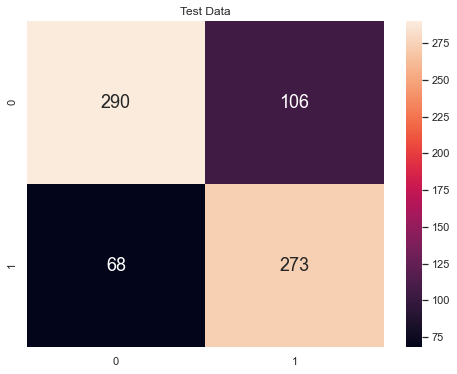

In [38]:
f = plt.figure(figsize = (8,6))
overviewHM = sb.heatmap(confusion_matrix(y_test, y_test_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
overviewHM.set_title('Test Data')

We can also use `plot_roc_curve` function to have a visualisation of the ROC curve.

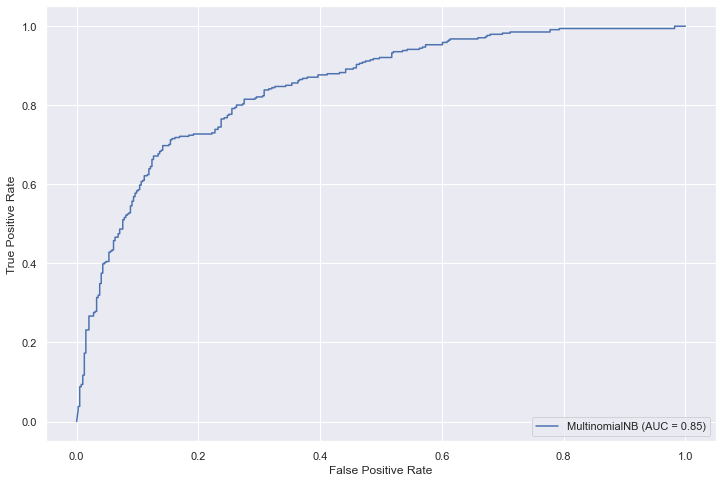

In [45]:
from sklearn.metrics import plot_roc_curve

f, axes = plt.subplots(1,1,figsize = (12,8))

plot_roc_curve(clfrNB, vect.transform(X_test), y_test, ax = axes)

# Conclusion

We can see that the unstructured data is a better predictor than the structured data of numerical predictors. Our binary classification model that used variables such as `Budget`, `Revenue` and `Vote Count` had a weaker performance in terms of accuracy as it more often classified movies as being `Non-Action` compared to `Action`. 

However, through the use of Natural Language Processing, our Multinomial Naive Bayes model is much more accurate at predicting whether a movie is an `Action` film. We can see that `Overview`, or the words in `Overview` to be exact, is the best predictor so far in solving our classification problem.

This insight may also have an impact on movie-making studios, as they would have to consider the way they phrase their overviews for future releases, knowing that the words they use have an effect as to whether their movie can be determined to be of a specific genre, or not. In this case it would be `Action`.

![The End](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fscrip.pharmaintelligence.informa.com%2F-%2Fmedia%2Feditorial%2Fscrip%2F2019%2F07%2Fsc1907_the-end_1422417179_1200.jpg%3Fw%3D790%26hash%3DBBF4E73F95903188E0E81AFC2459E6A6F80BAF57&f=1&nofb=1)